In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


from mpl_toolkits import mplot3d

%matplotlib inline

In [11]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n, 2)).reshape(-1, 2)
    y0 = torch.zeros((n, 1))
    
    x1 = d1.sample((n, 2)).reshape(-1, 2)
    y1 = torch.ones((n, 1))
    
    return torch.cat( [x0, x1], 0 ), torch.cat( [y0, y1], 0 )

In [4]:
d0 = torch.distributions.Normal(torch.tensor([mu0]), torch.tensor([sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))

In [5]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.3945,  0.0873]), tensor(0.6068)]


In [6]:
log_freq = 500
for i in range(50000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 1.214931
Ошибка после 1 итераций: 0.303844
Ошибка после 2 итераций: 0.180550
Ошибка после 3 итераций: 0.134082
Ошибка после 4 итераций: 0.109152
Ошибка после 5 итераций: 0.094820
Ошибка после 6 итераций: 0.083672
Ошибка после 7 итераций: 0.075733
Ошибка после 8 итераций: 0.071211
Ошибка после 9 итераций: 0.065993
Ошибка после 10 итераций: 0.062187
Ошибка после 11 итераций: 0.059305
Ошибка после 12 итераций: 0.056263
Ошибка после 13 итераций: 0.054368
Ошибка после 14 итераций: 0.053160
Ошибка после 15 итераций: 0.051193
Ошибка после 16 итераций: 0.049776
Ошибка после 17 итераций: 0.048554
Ошибка после 18 итераций: 0.047252
Ошибка после 19 итераций: 0.046567
Ошибка после 20 итераций: 0.045438
Ошибка после 21 итераций: 0.044687
Ошибка после 22 итераций: 0.043869
Ошибка после 23 итераций: 0.042820
Ошибка после 24 итераций: 0.042584
Ошибка после 25 итераций: 0.041204
Ошибка после 26 итераций: 0.040948
Ошибка после 27 итераций: 0.041066
Ошибка после 28 итераций: 0.04

In [7]:
width = 200

x_scale = np.linspace(-10, 10, width)
y_scale = np.linspace(-10, 10, width)

X, Y = np.meshgrid(x_scale, y_scale)

points = np.stack([X, Y], axis=2)
xy_tensor = torch.tensor(points, dtype=torch.float)
with torch.no_grad():
    predictions = torch.sigmoid(layer(xy_tensor)).reshape([width, width]).numpy()

d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)

D0_l, D0_r = np.meshgrid( d0_pdf, d0_pdf )
D0 = D0_l * D0_r

D1_l, D1_r = np.meshgrid( d1_pdf, d1_pdf )
D1 = D1_l * D1_r

R = D1 / (D0 + D1)

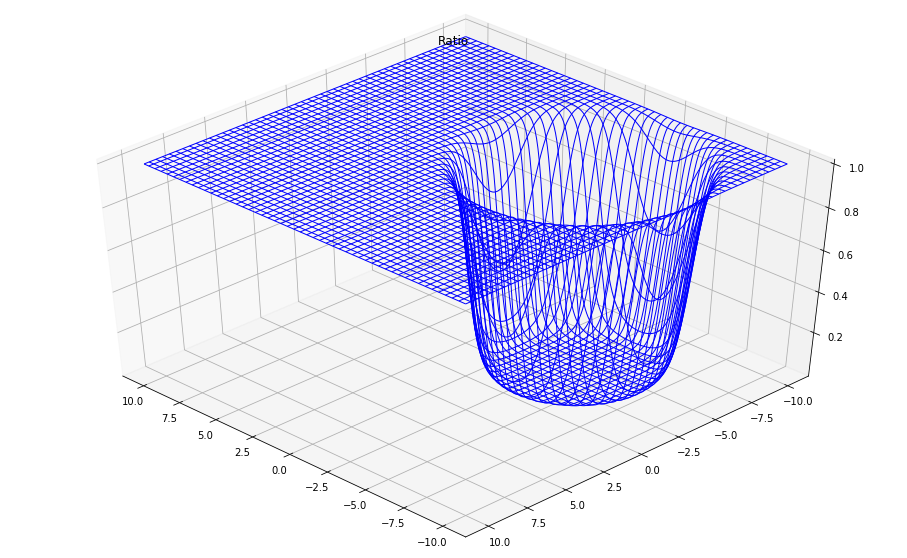

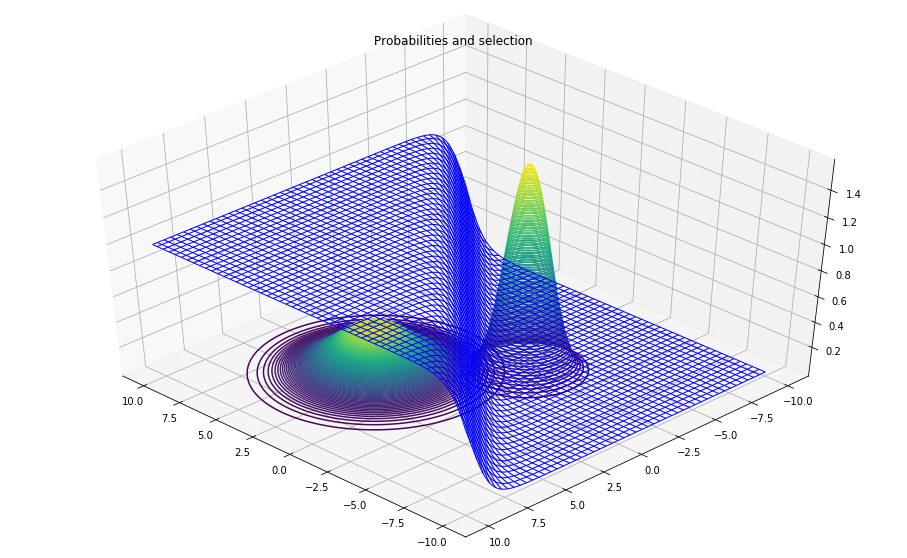

In [13]:
plt.figure(figsize=(16, 10))

ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, R, 1, color='blue')
ax.set_title('Ratio')

ax.view_init(45, 135)
plt.show()

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, predictions, 1, color='blue')
ax.contour3D(X, Y, D1 * 10, 100, cmap='viridis')
ax.contour3D(X, Y, D0 * 10, 100, cmap='viridis')
ax.set_title('Probabilities and selection')

ax.view_init(45, 135)

plt.show()

In [1]:
from torch.distributions import multivariate_normal

In [2]:
multivariate_normal

<module 'torch.distributions.multivariate_normal' from 'c:\\program files\\python36\\lib\\site-packages\\torch\\distributions\\multivariate_normal.py'>

In [38]:
import numpy as np

mus = torch.tensor([ 5, -4 ], dtype=torch.float32)
cov_matrix = torch.tensor([
    [16, 0], 
    [0, 4]
], dtype=torch.float32)
distr = multivariate_normal.MultivariateNormal(mus, covariance_matrix=cov_matrix)

In [41]:
distr.sample([10])

tensor([[ 9.8799, -6.1370],
        [-3.5169, -5.3380],
        [ 4.3771, -5.8158],
        [ 5.6173, -7.3451],
        [ 8.9696, -6.9776],
        [ 6.9177, -5.2391],
        [ 5.7642, -6.9017],
        [ 6.6327, -1.7054],
        [ 5.1471, -3.0069],
        [ 3.4152, -3.3209]])